# Forecasting with Python ARIMA

This notebook explores and experiments with data forecasting models. The notebook is divided into sections with each section representing indicators present in the data set. Each section has the following structure:
1. Data Wrangling: the data per indicator is split off from the imported dataset and made into a series.
2. Data Exploration: the data is plotted using line plots, and seasonal decompose to visualise any trends and/or seasonality in the data.
3. Statistical Testing: the data is tested to determine parameters to be passed into ARIMA/SARIMA(X) model as needed.
4. Perseistence: a persistence model is used to forecast the data to make a bassline for expected performance.
5. Parameter Testing: the data is used for forecasting with Auto ARIMA which searches a grid space for the best model.
6. Model Testing and Evaluation: models and configuration with the best performance is used to forecast the data and evaluated with RMSE, MAPE and R-squared.

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse

# Importing the excel sheet and displaying information about the sheet.
imported_sheet = pd.read_csv("forecast_data.csv", parse_dates=['Period'], index_col='Period')

print(f"Columns present in data: {imported_sheet.columns} \n")

print(f"Indicators present in data: {imported_sheet['Indicator'].unique()}")

print(imported_sheet.head())

Columns present in data: Index(['Indicator', 'State', 'LGA', 'Source', 'Value'], dtype='object') 

Indicators present in data: ['Adolescent birth rate' 'ANC Coverage (4 visits)'
 'ANC Coverage (at least 1 visit)' 'Contraceptive prevalence rate'
 'DPT 3/Penta 3 coverage rate' 'Infant Mortality rate'
 'Maternal Mortality Ratio' 'Measles Immunization Coverage'
 'Neonatal mortality rate (per 1000 live births)'
 'Percentage of children under 6 months who were exclusively breastfed'
 'Percentage of children with diarrhoea who received treatment'
 'Percentage of women age 15-49 years who received at least two or more IPT doses during pregnancy'
 'Postnatal care coverage (mother)' 'Prevalence of HIV'
 'Prevalence of stunting among under 5 children'
 'Prevalence of wasting among under 5 children'
 'Skilled attendance at delivery or birth' 'Total fertility rate'
 'Under 5 Mortality rate' 'Underweight prevalence among under 5 children'
 'Unmet need for family planning' 'Vitamin A supplementation 

In [99]:
def sheet_splitter(example_sheet, indicator):
    """
    a function that checks if an indicator is present in an example sheet,
    splits the example sheet based on the provided indicator and then,
    outputs a CSV file and determines whether time series forecasts,
    can be performed on the split data. Expects at least 15 data points,
    to pass check

    Args:
    example_sheet-pandas dataframe
    indicator-string

    Return:
    indicator_df-dataFrame
    """
    
    # Declare the indicator conditional
    indicator_conditional = example_sheet['Indicator'] == indicator
    
    # Make of copy of a slice of the original dataframe
    indicator_df = example_sheet[indicator_conditional].copy()
    
    # Determine how many data points are suitable for data forecasting
    if (len(indicator_df) >= 15):
        print(f"Indicator : {indicator}, with length: {len(indicator_df)} can be forecast")
        return indicator_df
        
    else:
        return f"""Indicator : {indicator} with length: {len(indicator_df)}, cannot be forecast, choose another indicator or check spelling"""
            
    
    

In [100]:
# import modules
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from math import sqrt

def persistence_model(series, split_ratio):
    """
    A function that implements a walk forward persistence model and 
    evaluates it using RMSE.

    Args:s
    series- pandas time series
    split_ratio- ratio of training set to test set- float(0.1-0.9)

    Returns:
    RMSE, MAPE, R2 Score 
    """
    
    # prepare data
    X = series.values
    years = series.index
    X = X.astype('float32')
    train_size = int(len(X) * split_ratio)
    # check if series and split length can compute
    if train_size > 0:
        train, test = X[0:train_size], X[train_size:]
        train_years, test_years = years[0:train_size], years[train_size:]

        # walk-forward validation
        history = [x for x in train]
        predictions = list()
        for i in range(len(test)):
            # predict
            yhat = history[-1]
            predictions.append(yhat)
            # observation
            obs = test[i]
            date = test_years[i]
            history.append(obs)
            print(f"{date:%Y}: Predicted={yhat:.3f}, Expected={obs:.3f}")

        # report performance
        rmse = sqrt(mean_squared_error(test, predictions))
        mape = (mean_absolute_percentage_error(test, predictions)) * 100
        r_2 = r2_score(test, predictions)
        print(f'RMSE: {rmse:.3f}')
        print(f'MAPE: {mape:.3f}%')
        print(f'r2 SCORE: {r_2:.3f}')
        return rmse, mape, r_2
    else:
        return """train set not large enough, supply a longer series or increase split ratio"""

In [101]:
def series_to_supervised(data, n_shift, dropnan=True):
    """
    a function which takes a time series and makes different lags,
    of the time series data. It then makes a dataframe containing,
    the original data and it's lags

    Args: 
    data-a time series
    n_shift-the number of lags the data should be shifted by
    dropnan-drop na values in the new dataframe, true by default

    Return
    final_supervised_data- DataFrame
    """
    # holds imported data
    df = pd.DataFrame(data)
    # holds lags as added
    cols = list()
    # holds the column names for new lags added
    names = list()

    # a loop which calls the shift function a given number of times
    for i in range(1, n_shift+1):
        cols.append(df.shift(i))
        names.append(f"Value-{i}")
    
    # the names for the created columns
    names.append("Value")
    # concatenate all the lags together
    agg = pd.concat(cols, axis=1)
    # concatenate imported data and lag list
    final_supervised_data = pd.concat([agg,data], axis=1)
    # rename columns
    final_supervised_data.columns = names

    # drop nan values if true
    if dropnan:
        final_supervised_data.dropna(inplace=True)

    return final_supervised_data


In [102]:
# import required modules
from statsmodels.tsa.stattools import adfuller

def adf_test(series, **kwargs):
    """
    a function that performs the augmented Dick-fuller statistical test
    to determine the unit root of a time series and the whether or not
    the time series being tested is stationary.

    Args:
    series- time series
    *kw- keyword arguments for the adfuller function
    """
    # Store result of the adf test
    result = adfuller(series, **kwargs)
    
    # Print results
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')
    return result[0], result[1]

In [103]:
# import required modules
from xgboost import XGBRegressor
from numpy import asarray

def xgboost_forecast(input_X, target_y, train_ratio=0.50, **kwargs):
    """
    A function that executes a xgboost algorithm on
    provided data.
    :params input_X-the features for the model
    :params target_y-the class/target variable
    :params train-ratio-ratio of train to test, range float 0.1-0.9, default=0.50
    :params kwargs- keyword arguments for xgboost

    """
    # list to store predictions
    predictions = list()
    # years present in the dataframe
    years = input_X.index
    
    # Change the values in the data to float type
    X = input_X.values
    input_X = X.astype('float32')

    # Change the values in the data to float type
    y = target_y.values
    target_y = y.astype('float32')
    
    # split data into train and test
    train_size = int(len(input_X) * train_ratio)
    X_train, X_test = input_X[0:train_size], input_X[train_size:]
    y_train, y_test = target_y[0:train_size], target_y[train_size:]
    train_years, test_years = years[0:train_size], years[train_size:]
    
    # walk-forward validation
    history = [x for x in X_train]
    futures = [y for y in y_train]
    
    # a loop to make one step predictions
    for i in range(len(y_test)):
        # predict
        model = XGBRegressor(objective='reg:squarederror', **kwargs)
        model.fit(asarray(history), asarray(futures))
        yhat = model.predict(X_test)
        result = yhat[0]
        predictions.append(result)
        date = test_years[i]

        # observation
        obs = X_test[i]
        history.append(obs)
        futures.append(y_test[i])
        print(f"{date:%Y}: Predicted={result:.3f}, Expected={y_test[i]:.3f}")

    # report performance
    rmse = sqrt(mean_squared_error(y_test, predictions))
    mape = (mean_absolute_percentage_error(y_test, predictions)) * 100
    r_2 = r2_score(y_test, predictions)
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'r2 SCORE: {r_2:.3f}')
    
    # plot performance
    test_list = list(y_test)
    results_df = pd.DataFrame(list(zip(test_list, predictions)), index=list(test_years),
                              columns=['test', 'predictions'])
    plt.plot(results_df['test'], label="Test Data")
    plt.plot(results_df['predictions'], color='red', label='Predictions')
    plt.title('XGBoost Predictions V Test Data')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return results_df


In [104]:
# import modules
from sklearn.linear_model import LinearRegression

def linear_regression_forecast(input_X, target_y, train_ratio=0.50):
    """
    a function that executes a linear regression model on provided data.
    :params input_X-the features for the model
    :params target_y-the class/target variable
    :params train-ratio-ratio of train to test, range float 0.1-0.9, default=0.50
    
    """
    # list to make predictions
    predictions = list()
    # years present within the data
    years = input_X.index
    
    # change values in data to float type
    X = input_X.values
    input_X = X.astype('float32')

    # change values in data to float type
    y = target_y.values
    target_y = y.astype('float32')
    
    # split data into test and train sets
    train_size = int(len(input_X) * train_ratio)
    X_train, X_test = input_X[0:train_size], input_X[train_size:]
    y_train, y_test = target_y[0:train_size], target_y[train_size:]
    train_years, test_years = years[0:train_size], years[train_size:]

    # walk-forward validation
    history = [x for x in X_train]
    futures = [y for y in y_train]
    # predictions = list()
    for i in range(len(y_test)):
        # predict
        model = LinearRegression()
        model.fit(asarray(history), asarray(futures))
        yhat = model.predict(X_test)
        result = yhat[0]
        predictions.append(result)
        date = test_years[i]

        # observation
        obs = X_test[i]
        history.append(obs)
        futures.append(y_test[i])
        print(f"{date:%Y}: Predicted={result:.3f}, Expected={y_test[i]:.3f}")
    
    # report performance
    rmse = sqrt(mean_squared_error(y_test, predictions))
    mape = (mean_absolute_percentage_error(y_test, predictions)) * 100
    r_2 = r2_score(y_test, predictions)
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R2 SCORE: {r_2:.3f}')

    # plot performance
    test_list = list(y_test)
    results_df = pd.DataFrame(list(zip(test_list, predictions)), index=list(test_years),
                              columns=['test', 'predictions'])
    plt.plot(results_df['test'], label='Test Data')
    plt.plot(results_df['predictions'], color='red', label='Predictions')
    plt.title("Linear Regression Predictions V Test Data")
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return results_df

In [105]:
# import modules
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

def ARIMA_forecast(series, p, d, q, split_ratio=0.50):
    """
    A function that makes a forecast using a ARIMA and evaluates 
    the model with RMSE.
    params: series-pandas series
    p: autoregressor term-int
    d: differencing term-int
    q: moving average term-int
    split_ratio: training set and test set ratio-float(0.1-0.9)
    """
    # make data into float type
    X = series.values
    X = X.astype('float32')
    # save dates present within data
    years = series.index

    #create train and test sets
    train_size = int(len(X) * split_ratio)
    train, test = X[0:train_size], X[train_size:]
    train_years, test_years = years[0:train_size], years[train_size:]
    
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    
    for i in range(len(test)):
        # predict
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        date = test_years[i]

        # observation
        obs = test[i]
        history.append(obs)
        print(f"{date:%Y}: Predicted={yhat:.3f}, Expected={obs:.3f}")

    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    mape = (mean_absolute_percentage_error(test, predictions)) * 100
    r_2 = r2_score(test, predictions)
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R2_SCORE: {r_2:.3f}')

    # plot performance
    test_list = list(test)
    results_df = pd.DataFrame(list(zip(test_list, predictions)), index=list(test_years),
                              columns=['test', 'predictions'])
    plt.plot(results_df['test'], label='Test Data')
    plt.plot(results_df['predictions'], color='red', label='Predictions')
    plt.title('ARIMA Predictions V Test Data')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return results_df

    


## Adolescent Birth rate
***
This section deals with forecasting the Adolescent birth rate, there are 30 data points for this indicator. 
The data was split 70%-30% for training and testing respectively.


### Results summary
1. Data is trend stationary; that is, it has an implicit trend.
2. ARIMA performs significantly better than the bassline.
3. Data could be improved if it is gathered on a more granular level such as monthly or daily.


In [106]:
# Split of the adolescent birth rate indicator rows from full dataset
ABR_sheet = sheet_splitter(imported_sheet, "Adolescent birth rate")

Indicator : Adolescent birth rate, with length: 30 can be forecast


In [107]:
# Display columns present within Adolescent birth rate sheet
ABR_sheet.columns

Index(['Indicator', 'State', 'LGA', 'Source', 'Value'], dtype='object')

In [108]:
# Drop columns not meaningful for forecasting
ABR_forecast = ABR_sheet.drop(['Indicator', 'State', 'LGA', 'Source'], axis=1)

In [111]:
# Line plot of Adolescent birth rates over time
ABR_forecast
# ABR_forecast.plot()

,Value
Period,
1990-01-01,148.0054
1991-01-01,145.7192
1992-01-01,143.4330
1993-01-01,142.0736
1994-01-01,140.7142
1995-01-01,139.3548
1996-01-01,137.9954
1997-01-01,136.6360
1998-01-01,135.3652


#### Observations
From the plot above, a very clear downward trend can be seen in the data, with one dip around 1992 and a bump around 2010. No seasonality is apparent from this plot, it also appears that there is very little noise in the data.

In [110]:
# # Import required module
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Multiplicative Decomposition 
# result_mul = seasonal_decompose(ABR_forecast['Value'], model='multiplicative', extrapolate_trend='freq')

# # Additive Decomposition
# result_add = seasonal_decompose(ABR_forecast['Value'], model='additive', extrapolate_trend='freq')

ABR_forecast['Value']

Period
1990-01-01    148.0054
1991-01-01    145.7192
1992-01-01    143.4330
1993-01-01    142.0736
1994-01-01    140.7142
1995-01-01    139.3548
1996-01-01    137.9954
1997-01-01    136.6360
1998-01-01    135.3652
1999-01-01    134.0944
2000-01-01    132.8236
2001-01-01    131.5528
2002-01-01    130.2820
2003-01-01    128.8608
2004-01-01    127.4396
2005-01-01    126.0184
2006-01-01    124.5972
2007-01-01    123.1760
2008-01-01    121.9508
2009-01-01    120.7256
2010-01-01    119.5004
2011-01-01    118.2752
2012-01-01    117.0500
2013-01-01    115.1060
2014-01-01    113.1620
2015-01-01    111.2180
2016-01-01    109.2740
2017-01-01    107.3300
2018-01-01    105.4470
2019-01-01    103.5640
Name: Value, dtype: float64

Text(0.5, 0.98, 'Multiplicative Decompose')

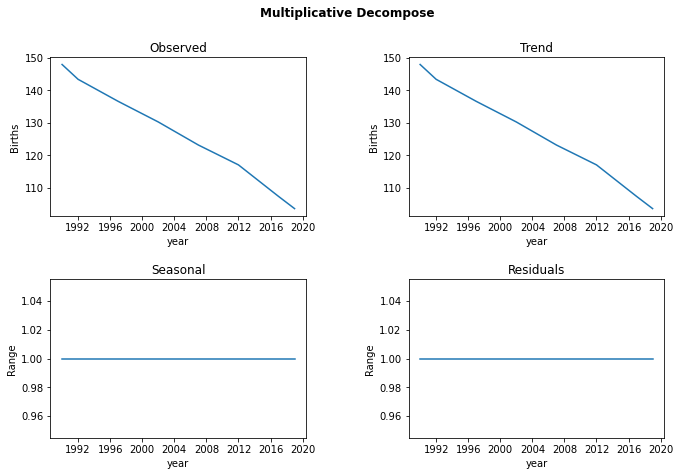

In [15]:
# plot multiplicative decompose
fig, ax = plt.subplots(2, 2)

fig.set_figwidth(11)
fig.set_figheight(7)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax[0,0].plot(result_mul.observed)
ax[0,0].set(xlabel='year', ylabel='Births', title='Observed')

ax[0,1].plot(result_mul.trend)
ax[0,1].set(xlabel='year', ylabel='Births', title='Trend')

ax[1,0].plot(result_mul.seasonal)
ax[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax[1,1].plot(result_mul.resid)
ax[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig.suptitle('Multiplicative Decompose', fontweight ="bold")

Text(0.5, 0.98, 'Additive Decompose')

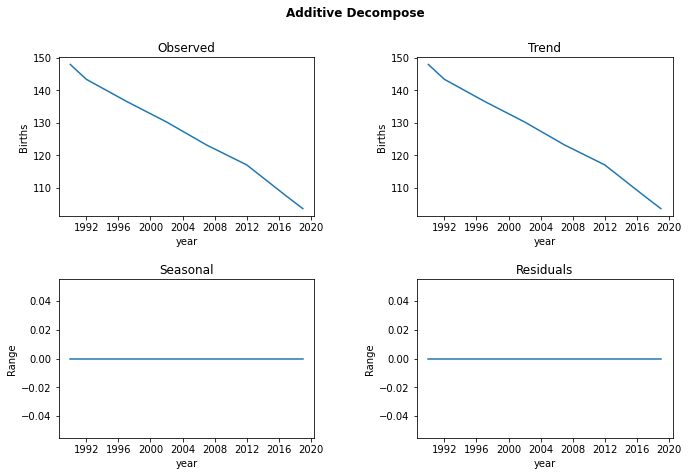

In [16]:
# plot additive decompose
fig1, ax1 = plt.subplots(2, 2)

fig1.set_figwidth(11)
fig1.set_figheight(7)
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

ax1[0,0].plot(result_add.observed)
ax1[0,0].set(xlabel='year', ylabel='Births', title='Observed')

ax1[0,1].plot(result_add.trend)
ax1[0,1].set(xlabel='year', ylabel='Births', title='Trend')

ax1[1,0].plot(result_add.seasonal)
ax1[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax1[1,1].plot(result_add.resid)
ax1[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig1.suptitle('Additive Decompose', fontweight ="bold")

#### Observations:
These two groups of plots above decompose the series, using multiplicative and additive methods. From the figures, it can be confirmed that there is no seasonality within the data. The decomposotion also shows us that most of the information in the series exists in the trends present within the Adolescent Birth Rate series. 

Another point to note is that both the additive and multiplicative decomposition of the series exposes the same information, and thus none has more explanatory power than the other. In the next cell we test for staionarity of the series.

In [17]:
# Test if the series is stationary
adf_test(ABR_forecast['Value'])

ADF Statistic: 2.352728939219174
p-value: 0.9989862979601905
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224
Result: The series is not stationary


(2.352728939219174, 0.9989862979601905)

In [18]:
# Moving the data by one difference.
ABR_forecast['1difference']=ABR_forecast['Value']-ABR_forecast['Value'].shift(1)

In [19]:
# Retest if the series is stationary
adf_test(ABR_forecast['1difference'].dropna())

ADF Statistic: -2.5559321787754636
p-value: 0.10245145525482174
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224
Result: The series is not stationary


(-2.5559321787754636, 0.10245145525482174)

In [20]:
# Move the data by another difference
ABR_forecast['2difference']=ABR_forecast['1difference']-ABR_forecast['1difference'].shift(1)

In [21]:
# Retest for stationarity
adf_test(ABR_forecast['2difference'].dropna())

ADF Statistic: -5.020918275792998
p-value: 2.0172024176192856e-05
Critical Values:
	1%: -3.6996079738860943
	5%: -2.9764303469999494
	10%: -2.627601001371742
Result: The series is stationary


(-5.020918275792998, 2.0172024176192856e-05)

c:\Users\Gloria\PycharmProjects\plotlyProject\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


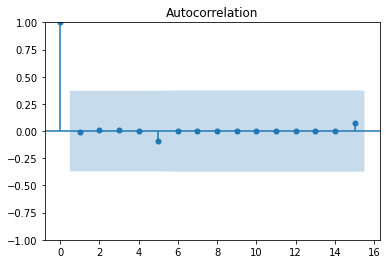

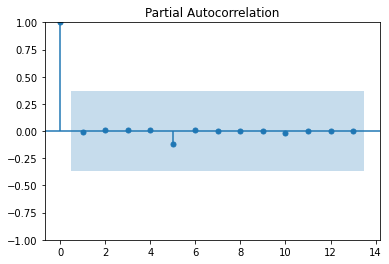

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting autocorrelation and partial correlation graphs to determine p,d,q for ARIMA Model
fig101=plot_acf(ABR_forecast['2difference'].dropna())
fig102=plot_pacf(ABR_forecast['2difference'].dropna(), lags=13)

#### Observations
From the Autocorrelation and Partial Correlation plots above, we can establish a range for the AR (p) and MA (q) terms. For MA we can use the autocorrelation plot to determine a range as to where the correlation between values becomes insignificant. In the plot above, this is after the zero mark, and such a good range would be 0-3 . For AR, we use the partial autocorrelation plot. In the plot we see that the correlation cuts off after lag-0, thus a good range would be from 0-3 .

In [23]:
# Testing a Persistence Model on the Time series data
persistence_model(ABR_forecast['Value'], 0.70)

2011: Predicted=119.500, Expected=118.275
2012: Predicted=118.275, Expected=117.050
2013: Predicted=117.050, Expected=115.106
2014: Predicted=115.106, Expected=113.162
2015: Predicted=113.162, Expected=111.218
2016: Predicted=111.218, Expected=109.274
2017: Predicted=109.274, Expected=107.330
2018: Predicted=107.330, Expected=105.447
2019: Predicted=105.447, Expected=103.564
RMSE: 1.795
MAPE: 1.603%
r2 SCORE: 0.864


(1.7947228853754909, 1.6034983098506927, 0.8641959180471533)

In [24]:
from pmdarima import auto_arima
import warnings

# Auto ARIMA to determine optimal Values for ARIMA parameters

warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(ABR_forecast['Value'].iloc[0:21],
                          start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12, 
                          start_P=0, seasonal=False,
                          d=2, D=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-0.701, Time=0.52 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1.205, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1.201, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1.448, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.532 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 2, 0)   Log Likelihood                   1.724
Date:                Wed, 01 Jun 2022   AIC                             -1.448
Time:                        10:25:48   BIC                             -0.503
Sample:                             0   HQIC                            -1.288
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0488      0.006      8.533      0.000       0.038       0.060
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               144.66
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             3.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2011: Predicted=118.275, Expected=118.275
2012: Predicted=117.050, Expected=117.050
2013: Predicted=115.825, Expected=115.106
2014: Predicted=113.162, Expected=113.162
2015: Predicted=111.218, Expected=111.218
2016: Predicted=109.274, Expected=109.274
2017: Predicted=107.330, Expected=107.330
2018: Predicted=105.386, Expected=105.447
2019: Predicted=103.564, Expected=103.564
RMSE: 0.240
MAPE: 0.076%
R2_SCORE: 0.998


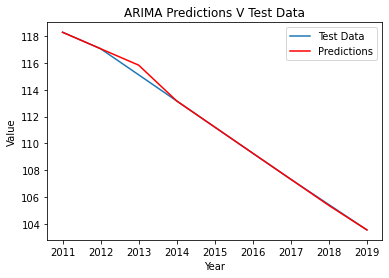

,test,predictions
2011-01-01,118.275200,118.275192
2012-01-01,117.050003,117.050003
2013-01-01,115.106003,115.824806
2014-01-01,113.162003,113.162003
2015-01-01,111.218002,111.218002
2016-01-01,109.274002,109.274002
2017-01-01,107.330002,107.330002
2018-01-01,105.446999,105.386002
2019-01-01,103.564003,103.563995


In [25]:
# Test a model with the best parameters
ARIMA_forecast(ABR_forecast['Value'], 0, 2, 0, split_ratio=0.70)

In [26]:
# Convert time series data to supervised ML data
ABR_supervised = series_to_supervised(ABR_forecast['Value'], n_shift=2)
print(ABR_supervised.head())


             Value-1   Value-2     Value
Period                                  
1992-01-01  145.7192  148.0054  143.4330
1993-01-01  143.4330  145.7192  142.0736
1994-01-01  142.0736  143.4330  140.7142
1995-01-01  140.7142  142.0736  139.3548
1996-01-01  139.3548  140.7142  137.9954


2011: Predicted=113.203, Expected=118.275
2012: Predicted=111.867, Expected=117.050
2013: Predicted=110.507, Expected=115.106
2014: Predicted=109.446, Expected=113.162
2015: Predicted=109.030, Expected=111.218
2016: Predicted=109.245, Expected=109.274
2017: Predicted=107.726, Expected=107.330
2018: Predicted=108.152, Expected=105.447
2019: Predicted=108.057, Expected=103.564
RMSE: 3.651
MAPE: 2.807%
r2 SCORE: 0.438


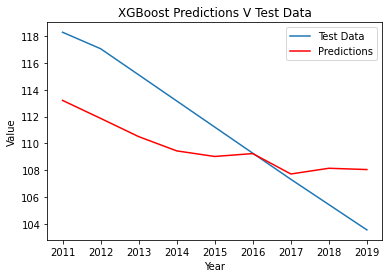

,test,predictions
2011-01-01,118.275200,113.202988
2012-01-01,117.050003,111.867371
2013-01-01,115.106003,110.506653
2014-01-01,113.162003,109.446281
2015-01-01,111.218002,109.029678
2016-01-01,109.274002,109.244728
2017-01-01,107.330002,107.726440
2018-01-01,105.446999,108.152100
2019-01-01,103.564003,108.056526


In [27]:
# Test Xgboost algorithm
xgboost_forecast(ABR_supervised.loc[:,["Value-1", "Value-2"]], ABR_supervised["Value"],
                train_ratio=0.70, learning_rate=0.1, n_estimators=23, alpha=5, max_depth=10)

2011: Predicted=118.261, Expected=118.275
2012: Predicted=118.264, Expected=117.050
2013: Predicted=118.265, Expected=115.106
2014: Predicted=118.161, Expected=113.162
2015: Predicted=118.140, Expected=111.218
2016: Predicted=118.133, Expected=109.274
2017: Predicted=118.130, Expected=107.330
2018: Predicted=118.128, Expected=105.447
2019: Predicted=118.131, Expected=103.564
RMSE: 8.515
MAPE: 6.522%
R2 SCORE: -2.057


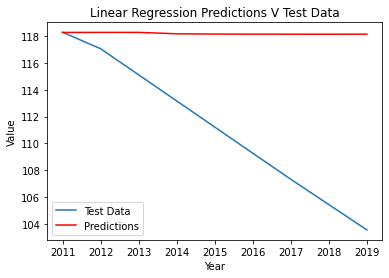

,test,predictions
2011-01-01,118.275200,118.260986
2012-01-01,117.050003,118.263596
2013-01-01,115.106003,118.264938
2014-01-01,113.162003,118.160622
2015-01-01,111.218002,118.140190
2016-01-01,109.274002,118.132690
2017-01-01,107.330002,118.129509
2018-01-01,105.446999,118.128365
2019-01-01,103.564003,118.131134


In [28]:
# Test Linear Regression algorithm
linear_regression_forecast(ABR_supervised.loc[:,["Value-1", "Value-2"]], ABR_supervised["Value"],
                           train_ratio=0.70)

### Discussion of Results
For the Adolescent Birth Rate time series, the ARIMA model above performes significantly better than a persistence(baseline) model, with *RMSE of 0.243* as opposed to *1.795* for the bassline model. The ARIMA model was trained with 21 of 30 (70%) data points, this performance could be further improved if the data is gathered on more granular level asuch as monthly/ daily

## DPT 3/ Penta 3 Coverage Rate
***
This section deals with forecasting the DPT 3 Coverage rate, there are 30 data points for this indicator. 
The data was split 70%-30% for training and testing respectively.


### Results summary
1. Data is possibly a random walk, and cannot be forecast with significant confidence.
2. ARIMA performs same as the bassline.

In [29]:
# Split of the DPT 3/Penta 3 coverage rate indicator rows from full dataset
DPT3_df = sheet_splitter(imported_sheet, "DPT 3/Penta 3 coverage rate")

Indicator : DPT 3/Penta 3 coverage rate, with length: 30 can be forecast


In [30]:
# Display columns present within DPT 3/Penta 3 coverage rate sheet
DPT3_df.columns

Index(['Indicator', 'State', 'LGA', 'Source', 'Value'], dtype='object')

In [31]:
# Drop columns not meaningful for forecasting
DPT3_forecast = DPT3_df.drop(['Indicator', 'State', 'LGA', 'Source'], axis=1)

<AxesSubplot:xlabel='Period'>

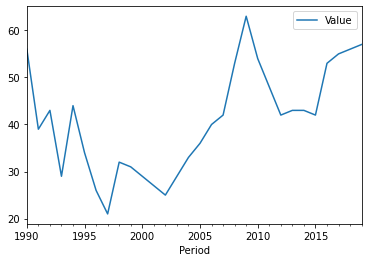

In [32]:
# Line plot of DPT 3/Penta 3 coverage rate over time
DPT3_forecast.plot()

#### Observation
The plot has a U like trend, with the possibility of noisy data. The plot also looks jagged with large swings within the plot.

In [33]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(DPT3_forecast['Value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(DPT3_forecast['Value'], model='additive', extrapolate_trend='freq')


Text(0.5, 0.98, 'Multiplicative Decompose')

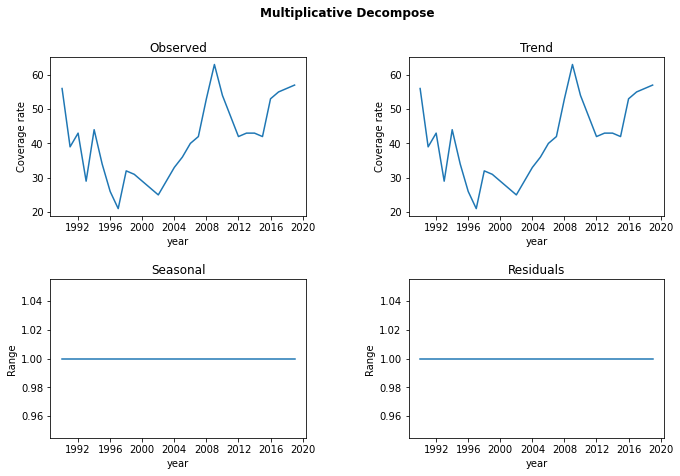

In [34]:
# Plotting multiplicative Decomposition
fig2, ax2 = plt.subplots(2, 2)

fig2.set_figwidth(11)
fig2.set_figheight(7)
fig2.subplots_adjust(hspace=0.4, wspace=0.4)

ax2[0,0].plot(result_mul.observed)
ax2[0,0].set(xlabel='year', ylabel='Coverage rate', title='Observed')

ax2[0,1].plot(result_mul.trend)
ax2[0,1].set(xlabel='year', ylabel='Coverage rate', title='Trend')

ax2[1,0].plot(result_mul.seasonal)
ax2[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax2[1,1].plot(result_mul.resid)
ax2[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig2.suptitle('Multiplicative Decompose', fontweight ="bold")

Text(0.5, 0.98, 'Additive Decompose')

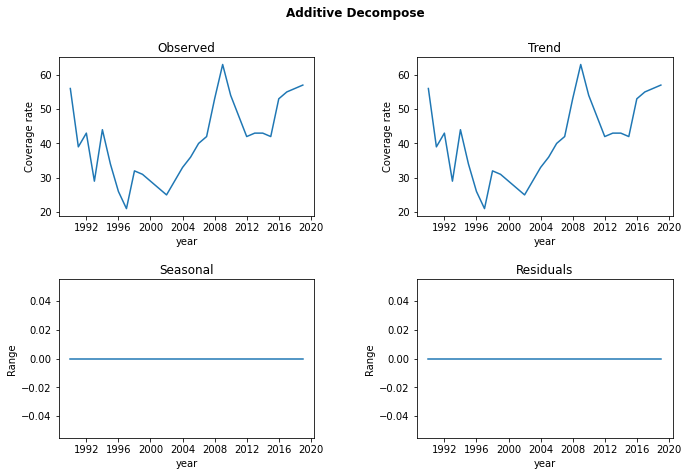

In [35]:
# Plotting Additive Decompose
fig3, ax3 = plt.subplots(2, 2)

fig3.set_figwidth(11)
fig3.set_figheight(7)
fig3.subplots_adjust(hspace=0.4, wspace=0.4)

ax3[0,0].plot(result_add.observed)
ax3[0,0].set(xlabel='year', ylabel='Coverage rate', title='Observed')

ax3[0,1].plot(result_add.trend)
ax3[0,1].set(xlabel='year', ylabel='Coverage rate', title='Trend')

ax3[1,0].plot(result_add.seasonal)
ax3[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax3[1,1].plot(result_add.resid)
ax3[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig3.suptitle('Additive Decompose', fontweight ="bold")

#### Observations
From the figures, it can be confirmed that there is no seasoanlity within the data. The decomposotion also shows us that most of the information in the series exists in the trends present within the DPT 3/Penta 3 coverage rate series. 
Another point to note is that both the additive and multiplicative decomposition of the series exposes the same information, and thus none has more explanatory power than the other. In the next cell we test for staionarity of the series.

In [36]:
# Testing the data for stationarity
adf_test(DPT3_forecast['Value'])

ADF Statistic: -1.0584096421456244
p-value: 0.7313696314405085
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224
Result: The series is not stationary


(-1.0584096421456244, 0.7313696314405085)

In [37]:
# Take a difference of the data since it wasn't stationary
DPT3_forecast['1difference']=DPT3_forecast['Value']-DPT3_forecast['Value'].shift(1)

In [38]:
# Retest the difference
adf_test(DPT3_forecast['1difference'].dropna())

ADF Statistic: -6.582658018222768
p-value: 7.4470942387319355e-09
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224
Result: The series is stationary


(-6.582658018222768, 7.4470942387319355e-09)

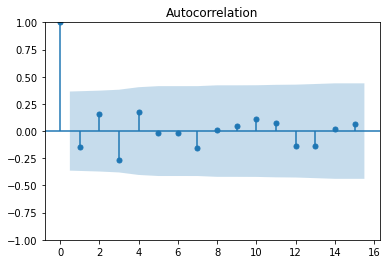

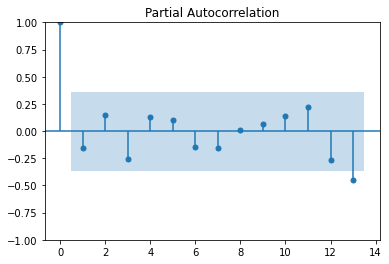

In [39]:
# Plot autocorelation and partial autocorrelation for the differenced series to determine,
# value range for p,d,q arguments for ARIMA
fig105=plot_acf(DPT3_forecast['1difference'].dropna())
fig106=plot_pacf(DPT3_forecast['1difference'].dropna(), lags=13)

#### Observations
From the Autocorrelation and Partial Correlation plots above, we can establish a range for the AR (p) and MA (q) terms. For MA we can use the autocorrelation plot to determine a range as to where the correlation between values becomes insignificant. In the plot above, this is after the zero mark, and such a good range would be 0-3 . For AR, we use the partial autocorrelation plot. In the plot we see that the correlation cuts off after lag-0, thus a good range would be from 0-3 .

In [40]:
# Call and evaluate a persistence model to establish a baseline
persistence_model(DPT3_forecast['Value'], 0.70)

2011: Predicted=54.000, Expected=48.000
2012: Predicted=48.000, Expected=42.000
2013: Predicted=42.000, Expected=43.000
2014: Predicted=43.000, Expected=43.000
2015: Predicted=43.000, Expected=42.000
2016: Predicted=42.000, Expected=53.000
2017: Predicted=53.000, Expected=55.000
2018: Predicted=55.000, Expected=56.000
2019: Predicted=56.000, Expected=57.000
RMSE: 4.726
MAPE: 6.603%
r2 SCORE: 0.401


(4.725815693519608, 6.602603197097778, 0.4009933722106638)

In [41]:
# Search for the best fit ARIMA model given the range of parameters
stepwise_fit = auto_arima(DPT3_forecast['Value'].iloc[0:21],
                          start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12, 
                          start_P=0, seasonal=False,
                          d=1, D=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=145.895, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=146.362, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=146.768, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=143.898, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=146.544, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.327 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -70.949
Date:                Wed, 01 Jun 2022   AIC                            143.898
Time:                        10:26:00   BIC                            144.894
Sample:                             0   HQIC                           144.093
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        70.6025     27.173      2.598      0.009      17.345     123.860
===================================================================================
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.25   Prob(JB):                         0.78
Heteroskedasticity (H):               0.38   Skew:                            -0.19
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2011: Predicted=54.000, Expected=48.000
2012: Predicted=48.000, Expected=42.000
2013: Predicted=42.000, Expected=43.000
2014: Predicted=43.000, Expected=43.000
2015: Predicted=43.000, Expected=42.000
2016: Predicted=42.000, Expected=53.000
2017: Predicted=53.000, Expected=55.000
2018: Predicted=55.000, Expected=56.000
2019: Predicted=56.000, Expected=57.000
RMSE: 4.726
MAPE: 6.603%
R2_SCORE: 0.401


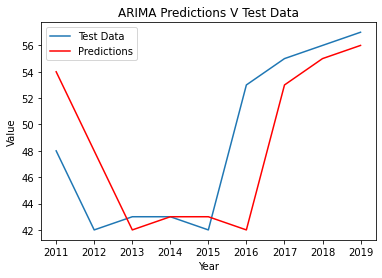

,test,predictions
2011-01-01,48.0,54.0
2012-01-01,42.0,48.0
2013-01-01,43.0,42.0
2014-01-01,43.0,43.0
2015-01-01,42.0,43.0
2016-01-01,53.0,42.0
2017-01-01,55.0,53.0
2018-01-01,56.0,55.0
2019-01-01,57.0,56.0


In [42]:
# Test best ARIMA from search.
ARIMA_forecast(DPT3_forecast['Value'], 0, 1, 0, split_ratio=0.70)

In [43]:
# Convert time series data to supervised ML data
DPT3_supervised = series_to_supervised(DPT3_forecast['Value'], n_shift=2)
print(DPT3_supervised.head())

            Value-1  Value-2  Value
Period                             
1992-01-01     39.0     56.0   43.0
1993-01-01     43.0     39.0   29.0
1994-01-01     29.0     43.0   44.0
1995-01-01     44.0     29.0   34.0
1996-01-01     34.0     44.0   26.0


2011: Predicted=48.991, Expected=48.000
2012: Predicted=47.835, Expected=42.000
2013: Predicted=47.312, Expected=43.000
2014: Predicted=47.839, Expected=43.000
2015: Predicted=47.978, Expected=42.000
2016: Predicted=47.969, Expected=53.000
2017: Predicted=47.939, Expected=55.000
2018: Predicted=47.991, Expected=56.000
2019: Predicted=47.998, Expected=57.000
RMSE: 6.084
MAPE: 11.544%
r2 SCORE: 0.007


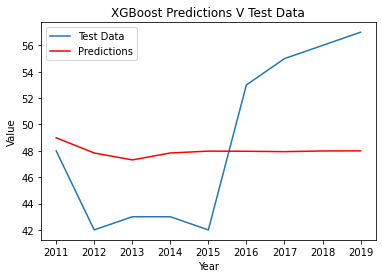

,test,predictions
2011-01-01,48.0,48.990822
2012-01-01,42.0,47.834999
2013-01-01,43.0,47.312168
2014-01-01,43.0,47.839130
2015-01-01,42.0,47.977905
2016-01-01,53.0,47.969154
2017-01-01,55.0,47.939026
2018-01-01,56.0,47.991432
2019-01-01,57.0,47.997707


In [44]:
# Test Xgboost algorithm
xgboost_forecast(DPT3_supervised.loc[:,["Value-1", "Value-2"]], DPT3_supervised["Value"],
                train_ratio=0.70, learning_rate=0.3, n_estimators=90, alpha=10, max_depth=10)

2011: Predicted=54.036, Expected=48.000
2012: Predicted=51.914, Expected=42.000
2013: Predicted=50.906, Expected=43.000
2014: Predicted=51.124, Expected=43.000
2015: Predicted=51.221, Expected=42.000
2016: Predicted=51.228, Expected=53.000
2017: Predicted=52.165, Expected=55.000
2018: Predicted=52.472, Expected=56.000
2019: Predicted=52.946, Expected=57.000
RMSE: 6.569
MAPE: 13.036%
R2 SCORE: -0.157


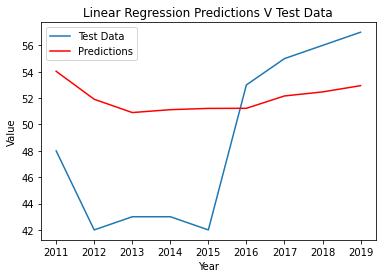

,test,predictions
2011-01-01,48.0,54.035965
2012-01-01,42.0,51.914326
2013-01-01,43.0,50.905685
2014-01-01,43.0,51.124004
2015-01-01,42.0,51.221218
2016-01-01,53.0,51.228336
2017-01-01,55.0,52.165398
2018-01-01,56.0,52.471657
2019-01-01,57.0,52.946121


In [45]:
# Test Linear Regression algorithm
linear_regression_forecast(DPT3_supervised.loc[:,["Value-1", "Value-2"]], DPT3_supervised["Value"],
                           train_ratio=0.70)

### Discussion of Results
The ARIMA model which produces the best result does not have any AR and MA terms, only one term for differencing, this suggests the data might be a random walk. The best performing ARIMA model has the same performance as a persistence model, also suggests that the data is a random walk and the trained model doesn't show better explanatory power than a model based on predicting previous steps.

## Infant Mortality Rate
***
This section deals with forecasting the Infant Mortality rate, there are 30 data points for this indicator. 
The data was split 70%-30% for training and testing respectively.


### Results summary
1. Data is a smooth downward trend.
2. ARIMA performs better than the bassline.

In [46]:
# Split of the infant mortality rate indicator rows from full dataset
IM_rate_df = sheet_splitter(imported_sheet, "Infant Mortality rate")

Indicator : Infant Mortality rate, with length: 30 can be forecast


In [47]:
# Display columns present within infant mortality rate sheet
IM_rate_df.columns

Index(['Indicator', 'State', 'LGA', 'Source', 'Value'], dtype='object')

In [48]:
# Drop columns not meaningful for forecasting
IM_rate_forecast = IM_rate_df.drop(['Indicator', 'State', 'LGA', 'Source'], axis=1)

<AxesSubplot:xlabel='Period'>

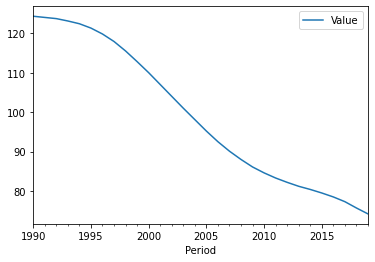

In [49]:
# Line plot of infant mortality over time
IM_rate_forecast.plot()

#### Observation
The plot has a smooth downward trend, with little or no noise in the data. 

In [50]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(IM_rate_forecast['Value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(IM_rate_forecast['Value'], model='additive', extrapolate_trend='freq')


Text(0.5, 0.98, 'Multiplicative Decompose')

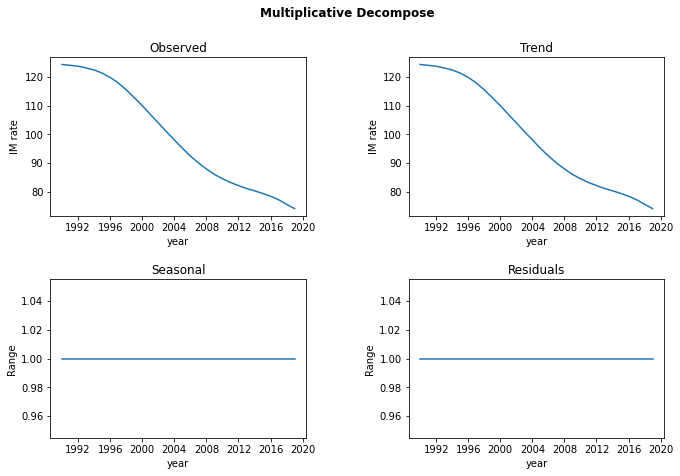

In [51]:
# Plotting Multiplicative Decomposition
fig4, ax4 = plt.subplots(2, 2)

fig4.set_figwidth(11)
fig4.set_figheight(7)
fig4.subplots_adjust(hspace=0.4, wspace=0.4)

ax4[0,0].plot(result_mul.observed)
ax4[0,0].set(xlabel='year', ylabel='IM rate', title='Observed')

ax4[0,1].plot(result_mul.trend)
ax4[0,1].set(xlabel='year', ylabel='IM rate', title='Trend')

ax4[1,0].plot(result_mul.seasonal)
ax4[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax4[1,1].plot(result_mul.resid)
ax4[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig4.suptitle('Multiplicative Decompose', fontweight ="bold")

Text(0.5, 0.98, 'Additive Decompose')

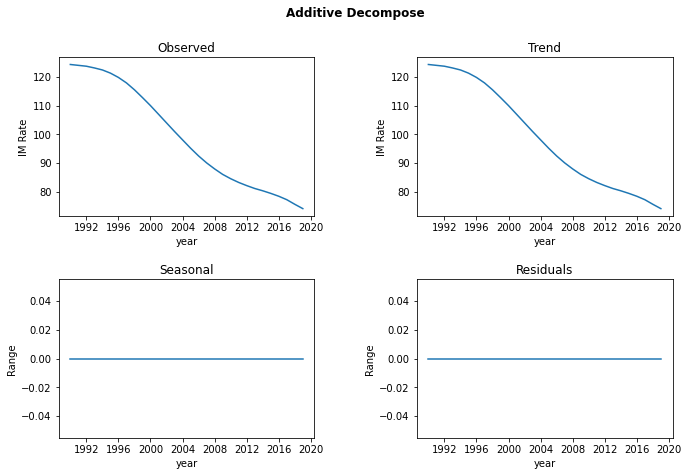

In [52]:
# Additive Decomposition
fig5, ax5 = plt.subplots(2, 2)

fig5.set_figwidth(11)
fig5.set_figheight(7)
fig5.subplots_adjust(hspace=0.4, wspace=0.4)

ax5[0,0].plot(result_add.observed)
ax5[0,0].set(xlabel='year', ylabel='IM Rate', title='Observed')

ax5[0,1].plot(result_add.trend)
ax5[0,1].set(xlabel='year', ylabel='IM Rate', title='Trend')

ax5[1,0].plot(result_add.seasonal)
ax5[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax5[1,1].plot(result_add.resid)
ax5[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig5.suptitle('Additive Decompose', fontweight ="bold")

#### Observations
From the figures, it can be confirmed that there is no seasoanlity within the data. The decomposotion also shows us that most of the information in the series exists in the trends present within the Infant Mortality rate series. 
Another point to note is that both the additive and multiplicative decomposition of the series exposes the same information, and thus none has more explanatory power than the other. In the next cell we test for staionarity of the series.

In [53]:
# Test the data for stationarity
adf_test(IM_rate_forecast['Value'])

ADF Statistic: 1.3475771721549257
p-value: 0.9968624803253752
Critical Values:
	1%: -3.8092091249999998
	5%: -3.0216450000000004
	10%: -2.6507125
Result: The series is not stationary


(1.3475771721549257, 0.9968624803253752)

In [54]:
# difference the series 
IM_rate_forecast['1difference']=IM_rate_forecast['Value']-IM_rate_forecast['Value'].shift(1)

In [55]:
# Testing the difference
adf_test(IM_rate_forecast['1difference'].dropna())

ADF Statistic: -4.558469251293847
p-value: 0.0001539567253131106
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004
Result: The series is stationary


(-4.558469251293847, 0.0001539567253131106)

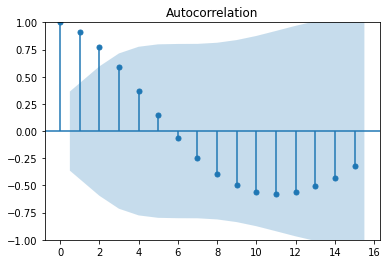

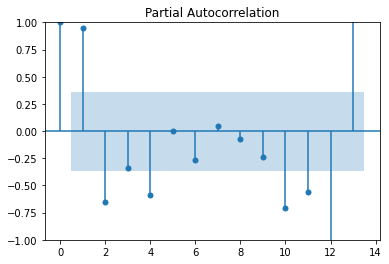

In [56]:
# Plot the partial and autocorrelation plots for the difference of the time series
fig111=plot_acf(IM_rate_forecast['1difference'].dropna())
fig112=plot_pacf(IM_rate_forecast['1difference'].dropna(), lags=13)

#### Observations
From the Autocorrelation and Partial Correlation plots above, we can establish a range for the AR (p) and MA (q) terms. For MA we can use the autocorrelation plot to determine a range as to where the correlation between values becomes insignificant. In the plot above, this is after the two lag, and such a good range would be 1-4 . For AR, we use the partial autocorrelation plot. In the plot we see that the correlation cuts off after lag-4, thus a good range would be from 2-5 .

In [57]:
# Call and test a persistence model to establish a baseline
persistence_model(IM_rate_forecast['Value'], 0.70)

2011: Predicted=84.600, Expected=83.300
2012: Predicted=83.300, Expected=82.200
2013: Predicted=82.200, Expected=81.200
2014: Predicted=81.200, Expected=80.400
2015: Predicted=80.400, Expected=79.500
2016: Predicted=79.500, Expected=78.500
2017: Predicted=78.500, Expected=77.300
2018: Predicted=77.300, Expected=75.700
2019: Predicted=75.700, Expected=74.200
RMSE: 1.183
MAPE: 1.469%
r2 SCORE: 0.827


(1.1832163999208885, 1.4687668532133102, 0.8265948660717113)

In [58]:
# Search for the best ARIMA model for the series
stepwise_fit = auto_arima(IM_rate_forecast['Value'].iloc[0:21],
                          start_p=2, start_q=1,
                          max_p=5, max_q=4, m=12, 
                          start_P=0, seasonal=False,
                          d=1, D=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.886, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.485, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.157, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8.729, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-15.193, Time=0.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-18.194, Time=0.57 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-15.407, Time=0.87 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-16.523, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16.276, Time=0.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-5.809, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-4.769, Time=0.26 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 6.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(3, 1, 1)   Log Likelihood                  15.097
Date:                Wed, 01 Jun 2022   AIC                            -18.194
Time:                        10:26:21   BIC                            -12.220
Sample:                             0   HQIC                           -17.028
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1382      0.044     -3.167      0.002      -0.224      -0.053
ar.L1          1.6709      0.357      4.679      0.000       0.971       2.371
ar.L2         -0.4873      0.695     -0.702      0.483      -1.849       0.874
ar.L3         -0.2632      0.358     -0.735      0.463      -0.965       0.439
ma.L1         -0.9389      0.698     -1.345      0.179      -2.307       0.429
sigma2         0.0080      0.006      1.256      0.209      -0.004       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.99   Prob(JB):                         0.75
Heteroskedasticity (H):               0.67   Skew:                             0.05
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2011: Predicted=83.469, Expected=83.300
2012: Predicted=82.333, Expected=82.200
2013: Predicted=81.298, Expected=81.200
2014: Predicted=80.356, Expected=80.400
2015: Predicted=79.740, Expected=79.500
2016: Predicted=78.687, Expected=78.500
2017: Predicted=77.399, Expected=77.300
2018: Predicted=76.036, Expected=75.700
2019: Predicted=73.841, Expected=74.200
RMSE: 0.211
MAPE: 0.237%
R2_SCORE: 0.994


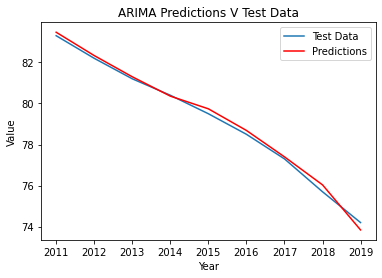

,test,predictions
2011-01-01,83.300003,83.468623
2012-01-01,82.199997,82.333080
2013-01-01,81.199997,81.298185
2014-01-01,80.400002,80.356405
2015-01-01,79.500000,79.739887
2016-01-01,78.500000,78.687412
2017-01-01,77.300003,77.399087
2018-01-01,75.699997,76.035999
2019-01-01,74.199997,73.841154


In [59]:
# Evaluate the best ARIMA model
ARIMA_forecast(IM_rate_forecast['Value'], 3, 1, 1, split_ratio=0.70)

In [60]:
# Convert time series data to supervised ML data
IM_rate_supervised = series_to_supervised(IM_rate_forecast['Value'], n_shift=2)
print(IM_rate_supervised.head())

            Value-1  Value-2  Value
Period                             
1992-01-01    124.0    124.3  123.7
1993-01-01    123.7    124.0  123.1
1994-01-01    123.1    123.7  122.4
1995-01-01    122.4    123.1  121.3
1996-01-01    121.3    122.4  119.8


2011: Predicted=81.593, Expected=83.300
2012: Predicted=80.723, Expected=82.200
2013: Predicted=80.120, Expected=81.200
2014: Predicted=79.700, Expected=80.400
2015: Predicted=78.534, Expected=79.500
2016: Predicted=78.196, Expected=78.500
2017: Predicted=78.187, Expected=77.300
2018: Predicted=78.208, Expected=75.700
2019: Predicted=77.729, Expected=74.200
RMSE: 1.742
MAPE: 1.874%
r2 SCORE: 0.624


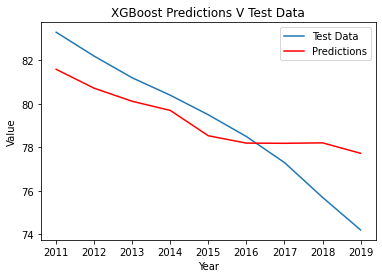

,test,predictions
2011-01-01,83.300003,81.593018
2012-01-01,82.199997,80.723076
2013-01-01,81.199997,80.120262
2014-01-01,80.400002,79.700172
2015-01-01,79.500000,78.533989
2016-01-01,78.500000,78.195755
2017-01-01,77.300003,78.187164
2018-01-01,75.699997,78.207909
2019-01-01,74.199997,77.728539


In [61]:
# Test Xgboost algorithm
xgboost_forecast(IM_rate_supervised.loc[:,["Value-1", "Value-2"]], IM_rate_supervised["Value"],
                train_ratio=0.70, learning_rate=0.1, n_estimators=27, alpha=5, max_depth=15)

2011: Predicted=83.564, Expected=83.300
2012: Predicted=83.475, Expected=82.200
2013: Predicted=83.421, Expected=81.200
2014: Predicted=83.364, Expected=80.400
2015: Predicted=83.344, Expected=79.500
2016: Predicted=83.287, Expected=78.500
2017: Predicted=83.247, Expected=77.300
2018: Predicted=83.206, Expected=75.700
2019: Predicted=83.156, Expected=74.200
RMSE: 5.000
MAPE: 5.433%
R2 SCORE: -2.097


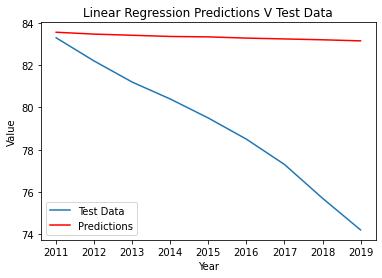

,test,predictions
2011-01-01,83.300003,83.563820
2012-01-01,82.199997,83.475197
2013-01-01,81.199997,83.420715
2014-01-01,80.400002,83.363724
2015-01-01,79.500000,83.344177
2016-01-01,78.500000,83.286545
2017-01-01,77.300003,83.246872
2018-01-01,75.699997,83.206413
2019-01-01,74.199997,83.155502


In [62]:
# Test Linear Regression algorithm
linear_regression_forecast(IM_rate_supervised.loc[:,["Value-1", "Value-2"]], IM_rate_supervised["Value"],
                           train_ratio=0.70)

### Discussion of Results.
The Time series for Infant mortality rate shows a smooth downward curve over time,and there is a significant difference in performance between the model *RMSE: 0.211* and the baseline *RMSE: 1.183* on the series. Assumption made on the data is that there is no seasonality in the data.

## Skilled attendance at delivery or birth
***
The data for Skilled attendance at delivery or birth is insufficent for forecasting, because it has a short length of 8, with some years within the data are skipped.

In [63]:
# Split of the adolescent birth rate indicator rows from full dataset
Skilled_birth_df = sheet_splitter(imported_sheet, "Skilled attendance at delivery or birth")

## Total fertility rate
***
This section deals with forecasting the Total fertility rate, there are 30 data points for this indicator. 
The data was split 70%-30% for training and testing respectively.


### Results summary
1. Data shows a smooth downward trend.
2. ARIMA is better than the baseline.

In [64]:
# Split of the Total fertility rate indicator rows from full dataset
TF_rate_df = sheet_splitter(imported_sheet, "Total fertility rate")

Indicator : Total fertility rate, with length: 30 can be forecast


In [65]:
# Display columns present within Total fertility rate sheet
TF_rate_df.columns

Index(['Indicator', 'State', 'LGA', 'Source', 'Value'], dtype='object')

In [66]:
# Drop columns not meaningful for forecasting
TF_rate_forecast = TF_rate_df.drop(['Indicator', 'State', 'LGA', 'Source'], axis=1)

<AxesSubplot:xlabel='Period'>

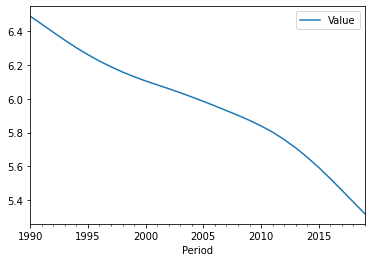

In [67]:
# Line plot of Total fertility rateover time
TF_rate_forecast.plot()

#### Observation
The plot is shows a slow smooth downward trend.

In [68]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(TF_rate_forecast['Value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(TF_rate_forecast['Value'], model='additive', extrapolate_trend='freq')

Text(0.5, 0.98, 'Multiplicative Decompose')

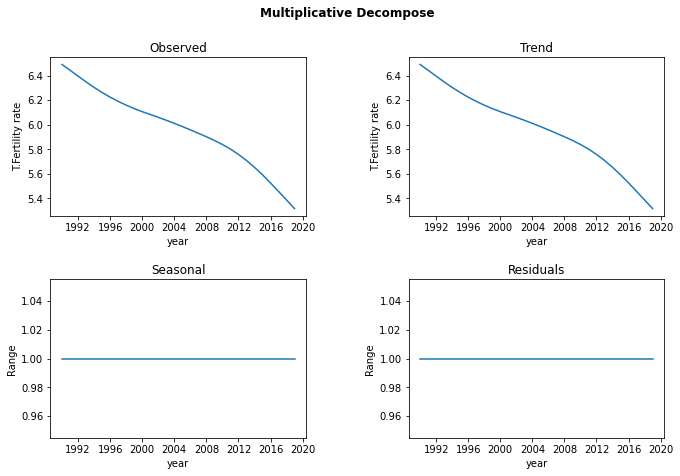

In [69]:
# plot multiplicative decompose
fig14, ax14 = plt.subplots(2, 2)

fig14.set_figwidth(11)
fig14.set_figheight(7)
fig14.subplots_adjust(hspace=0.4, wspace=0.4)

ax14[0,0].plot(result_mul.observed)
ax14[0,0].set(xlabel='year', ylabel='T.Fertility rate', title='Observed')

ax14[0,1].plot(result_mul.trend)
ax14[0,1].set(xlabel='year', ylabel='T.Fertility rate', title='Trend')

ax14[1,0].plot(result_mul.seasonal)
ax14[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax14[1,1].plot(result_mul.resid)
ax14[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig14.suptitle('Multiplicative Decompose', fontweight ="bold")

Text(0.5, 0.98, 'Additive Decompose')

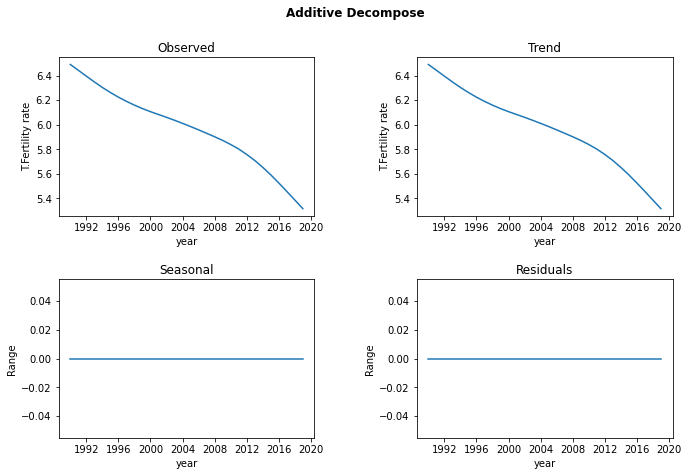

In [70]:
# Plot additive decompose
fig15, ax15 = plt.subplots(2, 2)

fig15.set_figwidth(11)
fig15.set_figheight(7)
fig15.subplots_adjust(hspace=0.4, wspace=0.4)

ax15[0,0].plot(result_add.observed)
ax15[0,0].set(xlabel='year', ylabel='T.Fertility rate', title='Observed')

ax15[0,1].plot(result_add.trend)
ax15[0,1].set(xlabel='year', ylabel='T.Fertility rate', title='Trend')

ax15[1,0].plot(result_add.seasonal)
ax15[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax15[1,1].plot(result_add.resid)
ax15[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig15.suptitle('Additive Decompose', fontweight ="bold")

#### Observations
From the figures, it can be confirmed that there is no seasoanlity within the data. The decomposotion also shows us that most of the information in the series exists in the trends present within the Total fertility rate series. 
Another point to note is that both the additive and multiplicative decomposition of the series exposes the same information, and thus none has more explanatory power than the other. In the next cell we test for staionarity of the series.

In [71]:
# Test for stationarity
adf_test(TF_rate_forecast['Value'])

ADF Statistic: 0.3559294327446255
p-value: 0.9797699078534454
Critical Values:
	1%: -3.7377092158564813
	5%: -2.9922162731481485
	10%: -2.635746736111111
Result: The series is not stationary


(0.3559294327446255, 0.9797699078534454)

In [72]:
# Take a difference of the data
TF_rate_forecast['1difference']=TF_rate_forecast['Value']-TF_rate_forecast['Value'].shift(1)

In [73]:
# Re-test for stationarity
adf_test(TF_rate_forecast['1difference'].dropna())

ADF Statistic: -3.55307487053271
p-value: 0.0067241684508432585
Critical Values:
	1%: -3.7112123008648155
	5%: -2.981246804733728
	10%: -2.6300945562130176
Result: The series is stationary


(-3.55307487053271, 0.0067241684508432585)

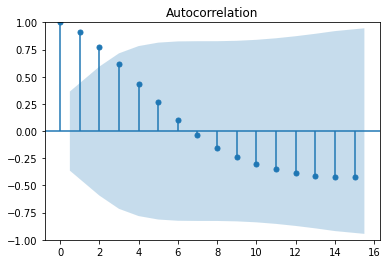

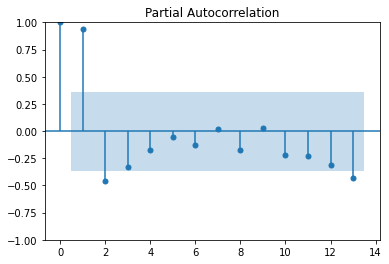

In [74]:
# Plot partial and auto correlation for the difference of total fertility rate
fig125=plot_acf(TF_rate_forecast['1difference'].dropna())
fig126=plot_pacf(TF_rate_forecast['1difference'].dropna(), lags=13)

#### Observations
From the Autocorrelation and Partial Correlation plots above, we can establish a range for the AR (p) and MA (q) terms. 
For MA we can use the autocorrelation plot to determine a range as to where the correlation between values becomes insignificant. In the plot above, this is after the two mark, and such a good range would be 1-4 . For AR, we use the partial autocorrelation plot. In the plot we see that the correlation cuts off after lag-2, thus a good range would be from 1-4 .

In [75]:
# Evaluate a persistence model 
persistence_model(TF_rate_forecast['Value'], 0.70)

2011: Predicted=5.839, Expected=5.802
2012: Predicted=5.802, Expected=5.758
2013: Predicted=5.758, Expected=5.709
2014: Predicted=5.709, Expected=5.653
2015: Predicted=5.653, Expected=5.592
2016: Predicted=5.592, Expected=5.526
2017: Predicted=5.526, Expected=5.457
2018: Predicted=5.457, Expected=5.387
2019: Predicted=5.387, Expected=5.317
RMSE: 0.059
MAPE: 1.046%
r2 SCORE: 0.862


(0.059142040877608826, 1.046263799071312, 0.8616292576490941)

In [76]:
# search for best parameters for ARIMA model
stepwise_fit = auto_arima(TF_rate_forecast['Value'].iloc[0:21],
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12, 
                          start_P=0, seasonal=False,
                          d=1, D=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-189.711, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-130.173, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-176.596, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-76.936, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-202.223, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-206.574, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-204.286, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-203.490, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-199.882, Time=0.16 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.604 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 107.287
Date:                Wed, 01 Jun 2022   AIC                           -206.574
Time:                        10:26:33   BIC                           -202.591
Sample:                             0   HQIC                          -205.797
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0034      0.001     -2.902      0.004      -0.006      -0.001
ar.L1          1.7126      0.108     15.842      0.000       1.501       1.924
ar.L2         -0.8127      0.107     -7.572      0.000      -1.023      -0.602
sigma2      1.022e-06   6.77e-07      1.509      0.131   -3.06e-07    2.35e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 2.13
Prob(Q):                              0.75   Prob(JB):                         0.35
Heteroskedasticity (H):               0.59   Skew:                            -0.80
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2011: Predicted=5.804, Expected=5.802
2012: Predicted=5.761, Expected=5.758
2013: Predicted=5.721, Expected=5.709
2014: Predicted=5.656, Expected=5.653
2015: Predicted=5.604, Expected=5.592
2016: Predicted=5.527, Expected=5.526
2017: Predicted=5.457, Expected=5.457
2018: Predicted=5.385, Expected=5.387
2019: Predicted=5.316, Expected=5.317
RMSE: 0.006
MAPE: 0.068%
R2_SCORE: 0.999


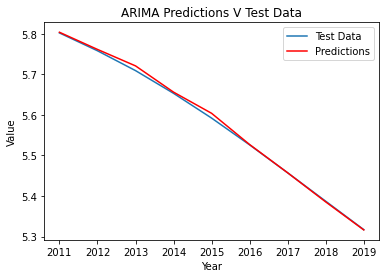

,test,predictions
2011-01-01,5.802,5.803636
2012-01-01,5.758,5.761332
2013-01-01,5.709,5.720665
2014-01-01,5.653,5.655948
2015-01-01,5.592,5.603814
2016-01-01,5.526,5.526817
2017-01-01,5.457,5.456988
2018-01-01,5.387,5.385298
2019-01-01,5.317,5.316354


In [77]:
# Evaluate best parameters on the data
ARIMA_forecast(TF_rate_forecast['Value'], 2, 1, 0, split_ratio=0.70)

In [78]:
# Convert time series data to supervised ML data
TF_rate_supervised = series_to_supervised(TF_rate_forecast['Value'], n_shift=2)
print(TF_rate_supervised.head())

            Value-1  Value-2  Value
Period                             
1992-01-01    6.443    6.490  6.395
1993-01-01    6.395    6.443  6.348
1994-01-01    6.348    6.395  6.303
1995-01-01    6.303    6.348  6.262
1996-01-01    6.262    6.303  6.224


2011: Predicted=5.590, Expected=5.802
2012: Predicted=5.590, Expected=5.758
2013: Predicted=5.589, Expected=5.709
2014: Predicted=5.585, Expected=5.653
2015: Predicted=5.581, Expected=5.592
2016: Predicted=5.575, Expected=5.526
2017: Predicted=5.570, Expected=5.457
2018: Predicted=5.565, Expected=5.387
2019: Predicted=5.559, Expected=5.317
RMSE: 0.148
MAPE: 2.322%
r2 SCORE: 0.130


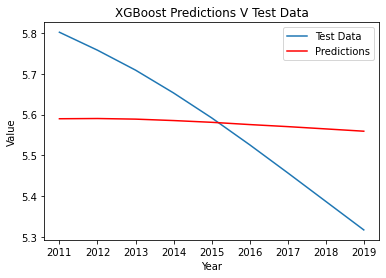

,test,predictions
2011-01-01,5.802,5.589753
2012-01-01,5.758,5.590317
2013-01-01,5.709,5.588820
2014-01-01,5.653,5.585325
2015-01-01,5.592,5.581037
2016-01-01,5.526,5.575484
2017-01-01,5.457,5.570434
2018-01-01,5.387,5.564826
2019-01-01,5.317,5.559187


In [79]:
# Test Xgboost algorithm
xgboost_forecast(TF_rate_supervised.loc[:,["Value-1", "Value-2"]], TF_rate_supervised["Value"],
                train_ratio=0.70, learning_rate=0.1, n_estimators=31, alpha=5, max_depth=15)

2011: Predicted=5.804, Expected=5.802
2012: Predicted=5.803, Expected=5.758
2013: Predicted=5.802, Expected=5.709
2014: Predicted=5.802, Expected=5.653
2015: Predicted=5.803, Expected=5.592
2016: Predicted=5.803, Expected=5.526
2017: Predicted=5.803, Expected=5.457
2018: Predicted=5.803, Expected=5.387
2019: Predicted=5.804, Expected=5.317
RMSE: 0.276
MAPE: 4.121%
R2 SCORE: -2.008


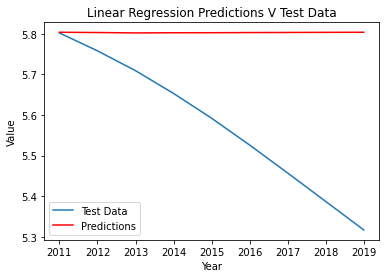

,test,predictions
2011-01-01,5.802,5.803706
2012-01-01,5.758,5.803027
2013-01-01,5.709,5.802051
2014-01-01,5.653,5.802482
2015-01-01,5.592,5.802535
2016-01-01,5.526,5.802941
2017-01-01,5.457,5.803192
2018-01-01,5.387,5.803459
2019-01-01,5.317,5.803705


In [80]:
# Test Linear Regression algorithm
linear_regression_forecast(TF_rate_supervised.loc[:,["Value-1", "Value-2"]], TF_rate_supervised["Value"],
                           train_ratio=0.70)

### Discussion of Results
On the Total Fertility time series, the data shows a smooth downward trend. The ARIMA model with *RMSE of *0.007* performs better than the baseline model *RMSE: 0.059* which is significant at 0.05 p-value. There might be seasonality within the data because of the shape of the partial and autocorrelation plots.

## Under 5 Mortality rate
***
This section deals with forecasting the Under 5 Mortality rate, there are 30 data points for this indicator. 
The data was split 70%-30% for training and testing respectively.


### Results summary
1. Data shows a smooth downward trend.
2. ARIMA is better than the baseline.

In [81]:
# Split of the Under 5 Mortality rate indicator rows from full dataset
U5_Mortality_rate_df = sheet_splitter(imported_sheet, "Under 5 Mortality rate")

Indicator : Under 5 Mortality rate, with length: 30 can be forecast


In [82]:
# Display columns present within Under 5 Mortality rate sheet
U5_Mortality_rate_df.columns

Index(['Indicator', 'State', 'LGA', 'Source', 'Value'], dtype='object')

In [83]:
# Drop columns not meaningful for forecasting
U5_mortality_rate_forecast = U5_Mortality_rate_df.drop(['Indicator', 'State', 'LGA', 'Source'], axis=1)

<AxesSubplot:xlabel='Period'>

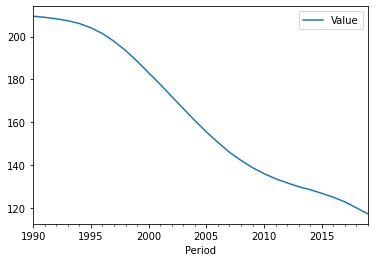

In [84]:
# Line plot of Under 5 Mortality rate over time
U5_mortality_rate_forecast.plot()

#### Observation
The plot is shows a smooth downward trend.

In [85]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(U5_mortality_rate_forecast['Value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(U5_mortality_rate_forecast['Value'], model='additive', extrapolate_trend='freq')

Text(0.5, 0.98, 'Multiplicative Decompose')

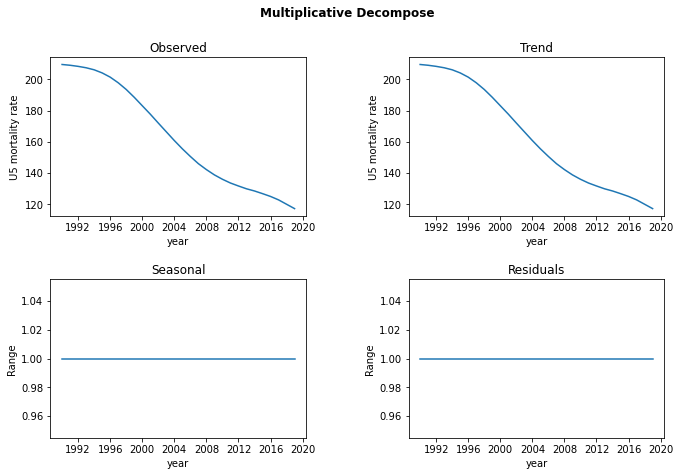

In [86]:
# Plot multiplicative decompose
fig16, ax16 = plt.subplots(2, 2)

fig16.set_figwidth(11)
fig16.set_figheight(7)
fig16.subplots_adjust(hspace=0.4, wspace=0.4)

ax16[0,0].plot(result_mul.observed)
ax16[0,0].set(xlabel='year', ylabel='U5 mortality rate', title='Observed')

ax16[0,1].plot(result_mul.trend)
ax16[0,1].set(xlabel='year', ylabel='U5 mortality rate', title='Trend')

ax16[1,0].plot(result_mul.seasonal)
ax16[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax16[1,1].plot(result_mul.resid)
ax16[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig16.suptitle('Multiplicative Decompose', fontweight ="bold")

Text(0.5, 0.98, 'Additive Decompose')

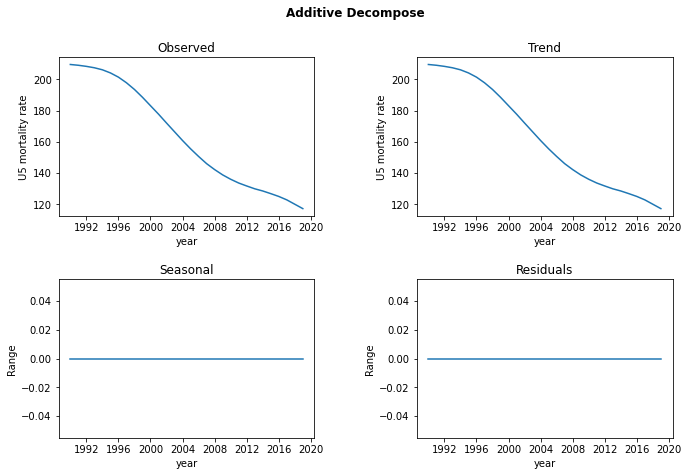

In [87]:
# plot additive decompose 
fig17, ax17 = plt.subplots(2, 2)

fig17.set_figwidth(11)
fig17.set_figheight(7)
fig17.subplots_adjust(hspace=0.4, wspace=0.4)

ax17[0,0].plot(result_add.observed)
ax17[0,0].set(xlabel='year', ylabel='U5 mortality rate', title='Observed')

ax17[0,1].plot(result_add.trend)
ax17[0,1].set(xlabel='year', ylabel='U5 mortality rate', title='Trend')

ax17[1,0].plot(result_add.seasonal)
ax17[1,0].set(xlabel='year', ylabel='Range', title='Seasonal')

ax17[1,1].plot(result_add.resid)
ax17[1,1].set(xlabel='year', ylabel='Range', title='Residuals')

fig17.suptitle('Additive Decompose', fontweight ="bold")

#### Observations
From the figures, it can be confirmed that there is no seasoanlity within the data. The decomposotion also shows us that most of the information in the series exists in the trends present within the Under 5 Mortality rate series. 
Another point to note is that both the additive and multiplicative decomposition of the series exposes the same information, and thus none has more explanatory power than the other. In the next cell we test for staionarity of the series.

In [88]:
# test for stationarity
adf_test(U5_mortality_rate_forecast['Value'])

ADF Statistic: 0.7763405980060374
p-value: 0.991244501041412
Critical Values:
	1%: -3.8092091249999998
	5%: -3.0216450000000004
	10%: -2.6507125
Result: The series is not stationary


(0.7763405980060374, 0.991244501041412)

In [89]:
# Take a difference of the data
U5_mortality_rate_forecast['1difference']=U5_mortality_rate_forecast['Value']-U5_mortality_rate_forecast['Value'].shift(1)

In [90]:
# Test the difference for stationarity
adf_test(U5_mortality_rate_forecast['1difference'].dropna())

ADF Statistic: -5.664440260069341
p-value: 9.22060020303368e-07
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004
Result: The series is stationary


(-5.664440260069341, 9.22060020303368e-07)

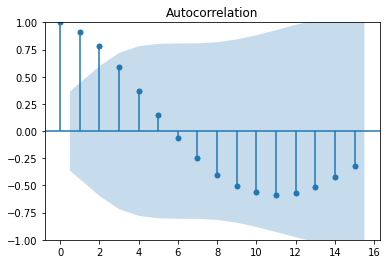

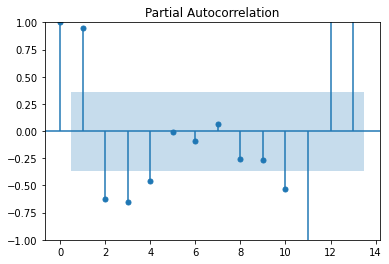

In [91]:
# plot partial and autocorrelation plots for U5 mortality rate
fig129=plot_acf(U5_mortality_rate_forecast['1difference'].dropna())
fig130=plot_pacf(U5_mortality_rate_forecast['1difference'].dropna(), lags=13)

#### Observations
From the Autocorrelation and Partial Correlation plots above, we can establish a range for the AR (p) and MA (q) terms. For MA we can use the autocorrelation plot to determine a range as to where the correlation between values becomes insignificant. In the plot above, this is after the two mark, and such a good range would be 1-4 . For AR, we use the partial autocorrelation plot. In the plot we see that the correlation cuts off after lag-4, thus a good range would be from 2-5 .

In [92]:
# Evaluate persistence (baseline) model
persistence_model(U5_mortality_rate_forecast['Value'], 0.70)

2011: Predicted=136.000, Expected=133.600
2012: Predicted=133.600, Expected=131.700
2013: Predicted=131.700, Expected=129.900
2014: Predicted=129.900, Expected=128.500
2015: Predicted=128.500, Expected=126.800
2016: Predicted=126.800, Expected=125.000
2017: Predicted=125.000, Expected=122.800
2018: Predicted=122.800, Expected=120.000
2019: Predicted=120.000, Expected=117.200
RMSE: 2.140
MAPE: 1.668%
r2 SCORE: 0.826


(2.1400941065123757, 1.667655073106289, 0.8259143009512082)

In [93]:
# search for optimal parameters for ARIMA model
stepwise_fit = auto_arima(U5_mortality_rate_forecast['Value'].iloc[0:21],
                          start_p=2, start_q=1,
                          max_p=5, max_q=4, m=12, 
                          start_P=0, seasonal=False,
                          d=1, D=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.223, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.055, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=114.922, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11.393, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1.912, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1.417, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-2.030, Time=0.66 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-0.396, Time=1.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-2.017, Time=0.71 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3.181, Time=0.51 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-0.100, Time=1.27 sec
 ARIMA(4,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(4, 1, 1)   Log Likelihood                   8.015
Date:                Wed, 01 Jun 2022   AIC                             -2.030
Time:                        10:26:51   BIC                              4.940
Sample:                             0   HQIC                            -0.670
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7860      0.235     -3.346      0.001      -1.246      -0.326
ar.L1          0.3741      0.178      2.105      0.035       0.026       0.722
ar.L2          1.1538      0.256      4.508      0.000       0.652       1.655
ar.L3          0.0457      0.232      0.197      0.844      -0.410       0.501
ar.L4         -0.8077      0.160     -5.037      0.000      -1.122      -0.493
ma.L1          0.9709      1.544      0.629      0.530      -2.056       3.998
sigma2         0.0150      0.019      0.802      0.422      -0.022       0.052
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.85   Prob(JB):                         0.53
Heteroskedasticity (H):               0.87   Skew:                             0.55
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2011: Predicted=133.615, Expected=133.600
2012: Predicted=131.640, Expected=131.700
2013: Predicted=130.090, Expected=129.900
2014: Predicted=128.301, Expected=128.500
2015: Predicted=127.070, Expected=126.800
2016: Predicted=125.147, Expected=125.000
2017: Predicted=122.726, Expected=122.800
2018: Predicted=120.265, Expected=120.000
2019: Predicted=116.638, Expected=117.200
RMSE: 0.251
MAPE: 0.161%
R2_SCORE: 0.998


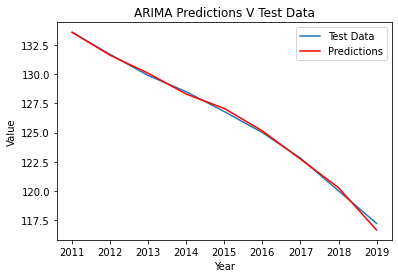

,test,predictions
2011-01-01,133.600006,133.614537
2012-01-01,131.699997,131.639803
2013-01-01,129.899994,130.090368
2014-01-01,128.500000,128.300634
2015-01-01,126.800003,127.069931
2016-01-01,125.000000,125.146566
2017-01-01,122.800003,122.725599
2018-01-01,120.000000,120.264783
2019-01-01,117.199997,116.638392


In [94]:
# Evaluate best parameters on data
ARIMA_forecast(U5_mortality_rate_forecast['Value'], 4, 1, 1, split_ratio=0.70)

In [95]:
# Convert time series data to supervised ML data
U5_mortality_rate_supervised = series_to_supervised(U5_mortality_rate_forecast['Value'], n_shift=2)
print(U5_mortality_rate_supervised.head())

            Value-1  Value-2  Value
Period                             
1992-01-01    209.0    209.5  208.3
1993-01-01    208.3    209.0  207.4
1994-01-01    207.4    208.3  206.1
1995-01-01    206.1    207.4  204.1
1996-01-01    204.1    206.1  201.4


2011: Predicted=131.258, Expected=133.600
2012: Predicted=127.625, Expected=131.700
2013: Predicted=127.688, Expected=129.900
2014: Predicted=126.869, Expected=128.500
2015: Predicted=124.695, Expected=126.800
2016: Predicted=124.065, Expected=125.000
2017: Predicted=123.546, Expected=122.800
2018: Predicted=122.753, Expected=120.000
2019: Predicted=122.442, Expected=117.200
RMSE: 2.800
MAPE: 1.956%
r2 SCORE: 0.702


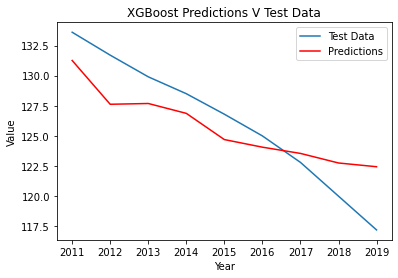

,test,predictions
2011-01-01,133.600006,131.257812
2012-01-01,131.699997,127.624840
2013-01-01,129.899994,127.688408
2014-01-01,128.500000,126.869179
2015-01-01,126.800003,124.695396
2016-01-01,125.000000,124.065468
2017-01-01,122.800003,123.546127
2018-01-01,120.000000,122.752991
2019-01-01,117.199997,122.442474


In [96]:
# Test Xgboost algorithm
xgboost_forecast(U5_mortality_rate_supervised.loc[:,["Value-1", "Value-2"]], U5_mortality_rate_supervised["Value"],
                train_ratio=0.70, learning_rate=0.1, n_estimators=25, alpha=5, max_depth=15)

2011: Predicted=134.044, Expected=133.600
2012: Predicted=133.899, Expected=131.700
2013: Predicted=133.832, Expected=129.900
2014: Predicted=133.699, Expected=128.500
2015: Predicted=133.667, Expected=126.800
2016: Predicted=133.544, Expected=125.000
2017: Predicted=133.483, Expected=122.800
2018: Predicted=133.405, Expected=120.000
2019: Predicted=133.324, Expected=117.200
RMSE: 8.954
MAPE: 6.106%
R2 SCORE: -2.047


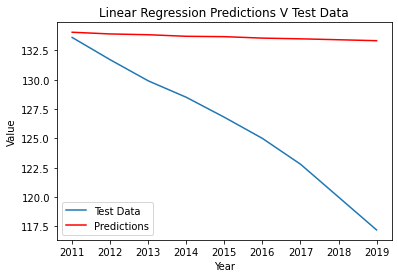

,test,predictions
2011-01-01,133.600006,134.043900
2012-01-01,131.699997,133.898682
2013-01-01,129.899994,133.831757
2014-01-01,128.500000,133.699341
2015-01-01,126.800003,133.667236
2016-01-01,125.000000,133.543991
2017-01-01,122.800003,133.482925
2018-01-01,120.000000,133.405090
2019-01-01,117.199997,133.324036


In [97]:
# Test Linear Regression algorithm
linear_regression_forecast(U5_mortality_rate_supervised.loc[:,["Value-1", "Value-2"]], U5_mortality_rate_supervised["Value"],
                           train_ratio=0.70)

### Discussion of Results
On the Total Fertility time series, the data shows a smooth downward trend. The ARIMA model with *RMSE of *0.252* performs significantly better than the baseline model *RMSE: 2.140*. There might be seasonality within the data because of the shape of the partial and autocorrelation plots.